# Precision and Recall

## Introduction
Precision and Recall is a method for evaluating pipelines, when given ground truth. I will be demonstrating how precision and recall works in this notebook on our connectLib pipeline. 

## Simulation Data

**Description:** Validation testing will be performed on a a 100x100x100 volume with a pixel intensity distribution approximately the same as that of the true image volumes (i.e., 98% background, 2% synapse). The synapse pixels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~1 micron ^3, or about 139 voxels (assuming the synthetic data here and the real world data have identical resolutions). After the data goes through the algorithm, I will gauge performance based on the following:

Precision: out of total clusters detected by pipeline, how many were actually true synapses.
Recall: out of total true synapses, how many were detected by the pipeline.


** Raw Synthetic Data:**

In [4]:
import sys
sys.path.insert(0, '../code/functions/')
import connectLib as cLib
from random import randrange as rand
import itertools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import math
from cluster import Cluster
from mpl_toolkits.mplot3d import Axes3D


def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 5):
        for y in range(-1, 5):
            for x in range(-1, 5):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    clusterList = []
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
            potentialPointSet = generatePointSet()
            clusterList.append(Cluster(list(potentialPointSet)))
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume, clusterList

testVolume = generateTestVolume()
foreground = testVolume[0]
combinedIm = testVolume[1]
trueClusterList = testVolume[2]


**What We Expect Our Simulation Data Will Look Like:**
The above code should generate a 100x100x100 volume and populate it with various, non-intersectting pointsets (representing foreground synpases). When the foreground is generated, the volume will then be introduced to random background noise which will fill the rest of the volume. 

###  Simulation Plots

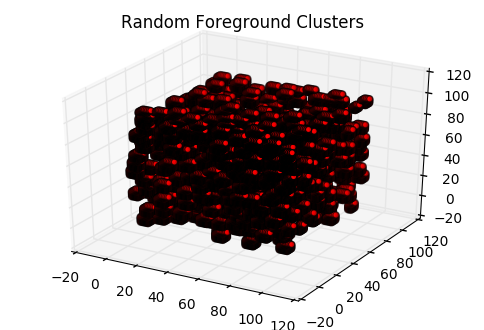

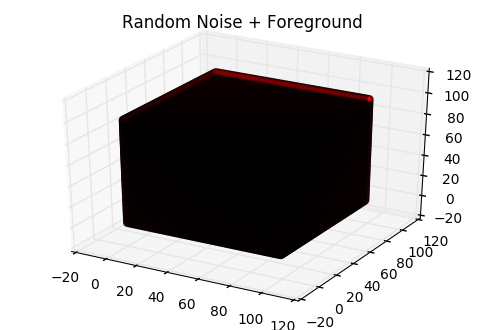

In [5]:
#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foreground.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground Clusters')
plt.show()

#displaying the noise
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = combinedIm.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Noise + Foreground')
plt.show()

**Why Our Simulation is Correct:** Real microscopic images of synapses usually contain a majority of background noise and relatively few synapse clusters. As shown above, the generated test volume follows this expectation. 

# Simulation Analysis

**For our algorithm, we define a cluster from the pipeline output as a true postive if any of its members is in the true synapse list. **

## Pseudocode for Precision and Recall

**Inputs: ** Two lists of synapse clusters

**Outputs: ** Precision and Recall Statistics.

In [ ]:
####Pseudocode: Will not run!####

#Step 1: Calculate True Postitives, False Negatives, and False Postitives.
FOR every synapse cluster in test volume:
    FOR every synapse cluster in true volume:
        IF test synapse cluster members in true synapse cluster members:
            True Postive Count + 1
        ELSE
            False Positive Count + 1
ENDFOR

FOR every synapse cluster in true volume:
    FOR every synapse cluster in test volume:
        IF true synapse cluster members not in test synapse cluster members:
            False Negative Count + 1

#Step 2: Calculate Precision and Recall.
Precision = True Positive Count / (False Postive Count + True Postive Count)
Recall = True Positive Count / (False Negative Count + True Positive Count)

#Step 3: Generate f1 Score. 
f1 = 2*Precision*Recall/ (Precision + Recall)

## Actual Code for Precision and Recall

In [20]:
def f1score(trueClusterList, testClusterList):
    tp = 0
    fp = 0
    fn = 0
    for testCluster in testClusterList:
        for trueCluster in trueClusterList:
            if (any(testCluster.members.tolist()) in trueCluster.members):
                tp+=1
            else:
                fp+=1
    for trueCluster in trueClusterList:
        for testCluster in testClusterList:
            if (any(testCluster.members.tolist()) not in (trueCluster.members)):
                fn+=1
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    return precision, recall, f1

## Pipeline code

In [8]:
import sys
sys.path.insert(0, '../functions/')
import cv2
import plosLib as pLib
import connectLib as cLib
from cluster import Cluster
import mouseVis as mv
import tiffIO as tIO
import cPickle as pickle
import hyperReg as hype
from scipy import ndimage
import matplotlib.pyplot as plt

def analyzeTimepoint(tiffImage, plosNeighborhood, plosLowerZBound, plosUpperZBound, debug=False):
    #finding the clusters after plosPipeline
    plosOut = pLib.pipeline(tiffImage, plosNeighborhood, plosLowerZBound, plosUpperZBound)
    #binarize output of plos lib
    bianOut = cLib.otsuVox(plosOut)
    
    #dilate the output based on neigborhood size
    for i in range(int((plosNeighborhood+plosUpperZBound+plosLowerZBound)/3.)):
        bianOut = ndimage.morphology.binary_dilation(bianOut).astype(int)
    #run connected component
    connectList = cLib.connectedComponents(bianOut)

    if debug:
        print connectList, bianOut

    return connectList

## Simulation Analysis
**What We Expect**
As previously mentioned, we believe the pipeline will work very well on the easy simulation (See Simulation Data for explanation).

**Generate Simulation Data:** See Simulation Data Above.

### Pipeline Run on Simulation Data

In [9]:
testClusterList = analyzeTimepoint(combinedIm, 1, 1, 1, True)

[<cluster.Cluster instance at 0x10767d440>, <cluster.Cluster instance at 0x1104d74d0>, <cluster.Cluster instance at 0x1104d7710>, <cluster.Cluster instance at 0x1104d7488>, <cluster.Cluster instance at 0x1104d7440>, <cluster.Cluster instance at 0x1104d7680>, <cluster.Cluster instance at 0x1104d7d88>, <cluster.Cluster instance at 0x1104d7dd0>, <cluster.Cluster instance at 0x110535c20>, <cluster.Cluster instance at 0x110535998>, <cluster.Cluster instance at 0x110535d40>, <cluster.Cluster instance at 0x110535b90>, <cluster.Cluster instance at 0x110535878>, <cluster.Cluster instance at 0x110535a70>, <cluster.Cluster instance at 0x110535b00>, <cluster.Cluster instance at 0x1105358c0>, <cluster.Cluster instance at 0x1105357a0>, <cluster.Cluster instance at 0x1105357e8>, <cluster.Cluster instance at 0x110535f80>, <cluster.Cluster instance at 0x110535908>, <cluster.Cluster instance at 0x110535cb0>, <cluster.Cluster instance at 0x110535098>, <cluster.Cluster instance at 0x1105359e0>, <cluster.C

In [10]:
print testClusterList

[<cluster.Cluster instance at 0x10767d440>, <cluster.Cluster instance at 0x1104d74d0>, <cluster.Cluster instance at 0x1104d7710>, <cluster.Cluster instance at 0x1104d7488>, <cluster.Cluster instance at 0x1104d7440>, <cluster.Cluster instance at 0x1104d7680>, <cluster.Cluster instance at 0x1104d7d88>, <cluster.Cluster instance at 0x1104d7dd0>, <cluster.Cluster instance at 0x110535c20>, <cluster.Cluster instance at 0x110535998>, <cluster.Cluster instance at 0x110535d40>, <cluster.Cluster instance at 0x110535b90>, <cluster.Cluster instance at 0x110535878>, <cluster.Cluster instance at 0x110535a70>, <cluster.Cluster instance at 0x110535b00>, <cluster.Cluster instance at 0x1105358c0>, <cluster.Cluster instance at 0x1105357a0>, <cluster.Cluster instance at 0x1105357e8>, <cluster.Cluster instance at 0x110535f80>, <cluster.Cluster instance at 0x110535908>, <cluster.Cluster instance at 0x110535cb0>, <cluster.Cluster instance at 0x110535098>, <cluster.Cluster instance at 0x1105359e0>, <cluster.C

### Simulation Results 

In [11]:
# get cluster members
def getClusterMembers(clusterList):
    memberList = []
    for cluster in clusterList:
        memberList.append(cluster.members)
    return memberList

print getClusterMembers(testClusterList)

[array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  2],
       ..., 
       [99, 99, 97],
       [99, 99, 98],
       [99, 99, 99]]), array([[ 0,  5, 56],
       [ 0,  5, 57],
       [ 0,  5, 58],
       [ 0,  5, 59],
       [ 0,  6, 56],
       [ 0,  6, 57],
       [ 0,  6, 58],
       [ 0,  6, 59],
       [ 0,  7, 56],
       [ 0,  7, 57],
       [ 0,  7, 58],
       [ 0,  7, 59],
       [ 0,  8, 56],
       [ 0,  8, 57],
       [ 0,  8, 58],
       [ 0,  8, 59],
       [ 1,  4, 56],
       [ 1,  4, 57],
       [ 1,  4, 58],
       [ 1,  4, 59],
       [ 1,  5, 55],
       [ 1,  5, 56],
       [ 1,  5, 57],
       [ 1,  5, 58],
       [ 1,  5, 59],
       [ 1,  5, 60],
       [ 1,  6, 55],
       [ 1,  6, 56],
       [ 1,  6, 57],
       [ 1,  6, 58],
       [ 1,  6, 59],
       [ 1,  6, 60],
       [ 1,  7, 55],
       [ 1,  7, 56],
       [ 1,  7, 57],
       [ 1,  7, 58],
       [ 1,  7, 59],
       [ 1,  7, 60],
       [ 1,  8, 55],
       [ 1,  8, 56],
       [ 1,  8, 57

In [22]:
# process true cluster list to contain lists of data points

for i in range(len(trueClusterList)):
    for j in range(len(trueClusterList[i].members)):
        trueClusterList[i].members[j] = list(trueClusterList[i].members[j])

print trueClusterList

print trueClusterList[0].members

[<cluster.Cluster instance at 0x10c9e3f80>, <cluster.Cluster instance at 0x10d2ef098>, <cluster.Cluster instance at 0x10d2ef128>, <cluster.Cluster instance at 0x10d2ef1b8>, <cluster.Cluster instance at 0x10d2ef248>, <cluster.Cluster instance at 0x10d2ef2d8>, <cluster.Cluster instance at 0x10d2ef368>, <cluster.Cluster instance at 0x10d2ef3f8>, <cluster.Cluster instance at 0x10d2ef488>, <cluster.Cluster instance at 0x10d2ef518>, <cluster.Cluster instance at 0x10d2ef5a8>, <cluster.Cluster instance at 0x10d2ef638>, <cluster.Cluster instance at 0x10d2ef6c8>, <cluster.Cluster instance at 0x10d2ef758>, <cluster.Cluster instance at 0x10d2ef7e8>, <cluster.Cluster instance at 0x10d2ef878>, <cluster.Cluster instance at 0x10d2ef908>, <cluster.Cluster instance at 0x10d2ef998>, <cluster.Cluster instance at 0x10d2efa28>, <cluster.Cluster instance at 0x10d2efab8>, <cluster.Cluster instance at 0x10d2efb48>, <cluster.Cluster instance at 0x10d2efbd8>, <cluster.Cluster instance at 0x10d2efc68>, <cluster.C

In [21]:
stats = f1score(trueClusterList, testClusterList)

ZeroDivisionError: integer division or modulo by zero

In [ ]:
print 'Precision:' + str(stats[0])
print 'Recall:' + str(stats[1])
print 'f1 Score:' + str(stats[2])